# 패키지 설치

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import time
import math
import argparse
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

from transformers import AutoTokenizer
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import AutoModel,ViTModel,ViTFeatureExtractor

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
# Drive Mount

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Working Directory 설정

import os
os.chdir('/content/gdrive/Shareddrives/주제분석/data')

In [ ]:
# EarlyStopping 설정

from EarlyStopping import *

In [ ]:
# 시드 설정

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# 데이터 전처리

In [ ]:
# 데이터 불러오기

df = pd.read_csv('ffinal_train.csv', encoding = 'cp949') ## 라벨 수정한 train dataset
df = df.iloc[:,:7]
df.drop('cat3', axis=1, inplace=True)
df.columns = ['id','img_path','overview','cat1','cat2','cat3']
df
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [ ]:
# 불용어 제거
import re

for i in tqdm(range(df.shape[0])):
    text = df.iloc[i, 2]
    text = text.replace('<br>','').replace('<br/>','').replace('*','').replace('<br /','').replace('&nbsp;','').replace('<a/>','').replace('<a />','').replace('\n','').replace('\t','')
    df.iloc[i, 2] = text

100%|██████████| 16965/16965 [00:02<00:00, 8400.92it/s]


In [ ]:
# 텍스트의 일정 비율을 제거해주는 함수

def RD(input: list, frac: float, seed=42):
    random.seed(seed)
    sentence = input.split('. ')
    del_list = []
    for s in sentence:
        text = s.split(' ')

        # 제거할 단어 수 지정
        if round(len(text) * frac) > 1:
            del_num = round(len(text) * frac)
        else:
            del_num = 1

        index = random.sample(range(len(text)), del_num)
        for i in sorted(index, reverse=True):
            del text[i]
        sentence_result = ' '.join(s for s in text)
        del_list.append(sentence_result)
    result = '. '.join(s for s in del_list)

    return result


# 텍스트의 일정 비율의 단어들의 순서를 바꿔줌

def RS(input: list, frac: float, seed=42):
    np.random.seed(seed)
    sentence = input.split('. ')
    swap_list = []
    for s in sentence:
        text = s.split(' ')

        if len(text) == 1:
            pass
        else:
        # 위치를 바꿔줄 단어 수 지정
            if round(len(text) * frac) > 2:
                swap_num = round(len(text) * frac)
            else:
                swap_num = 2

            index = random.sample(range(len(text)), swap_num)

            for i in range(len(index) - 1):
                text[index[i]], text[index[i + 1]] = text[index[i + 1]], text[index[i]]
            sentence_result = ' '.join(s for s in text)
            swap_list.append(sentence_result)
    result = '. '.join(s for s in swap_list)

    return result

In [ ]:
random.seed(42)
count_df = pd.DataFrame()
count_df = df['cat3'].value_counts().rename_axis('unique_values').reset_index(name='counts')

for i in range(count_df.shape[0]):
    count_df.counts[i] = df.shape[0] / count_df.counts[i]

root_list = []
for i in range(count_df.shape[0]):
    root_list.append(count_df.counts[i] ** (1/3))

count_df.counts = root_list

x_min = count_df.counts.min()
x_max = count_df.counts.max()

weight_list=[]
for i in range(count_df.shape[0]):
    weight_list.append((count_df.counts[i]-x_min)/(x_max - x_min))

count_df.counts = weight_list
df = pd.merge(df, count_df, how='left', left_on='cat3', right_on='unique_values')

mode_list = []

for i in range(df.shape[0]):
    mode_list.append(random.choices(range(0, 2), weights = [(1-df.counts[i]), df.counts[i]]))

mode_list = sum(mode_list, [])
df["mode"] = mode_list
df

,id,img_path,overview,cat1,cat2,cat3,unique_values,counts,mode
0,TRAIN_00000,./image/train/TRAIN_00000.jpg,소안항은 조용한 섬으로 인근해안이 청정해역으로 일찍이 김 양식을 해서 높은 소득을 ...,자연,자연관광지,항구/포구,항구/포구,0.140444,0
1,TRAIN_00001,./image/train/TRAIN_00001.jpg,경기도 이천시 모가면에 있는 골프장으로 대중제 18홀이다. 회원제로 개장을 했다가 ...,레포츠,육상 레포츠,골프,골프,0.122759,0
2,TRAIN_00002,./image/train/TRAIN_00002.jpg,금오산성숯불갈비는 한우고기만을 전문적으로 취급하고 사용하는 부식 자재 또한 유기농법...,음식,음식점,한식,한식,0.000000,0
3,TRAIN_00003,./image/train/TRAIN_00003.jpg,철판 위에서 요리하는 안동찜닭을 맛볼 수 있는 곳이다. 경상북도 안동시에 있는 한식...,음식,음식점,한식,한식,0.000000,0
4,TRAIN_00004,./image/train/TRAIN_00004.jpg,※ 영업시간 10:30 ~ 20:303대에 걸쳐 아귀만을 전문으로 취급하는 전통과 ...,음식,음식점,한식,한식,0.000000,0
...,...,...,...,...,...,...,...,...,...
16960,TRAIN_16981,./image/train/TRAIN_16981.jpg,해발 12000m에 자리한 식담겸 카페점문점이다.곤드레밥과 감자전을 판매하고 있다.,음식,음식점,한식,한식,0.000000,0
16961,TRAIN_16982,./image/train/TRAIN_16982.jpg,설악힐호텔은 동해고속도로 속초톨게이트에서 멀지 않은 관광로 변에 있다. 속초의 대표...,숙박,숙박시설,모텔,모텔,0.081695,0
16962,TRAIN_16983,./image/train/TRAIN_16983.jpg,충남 서산시 중심가에 위치한 줌모텔은 프라이버스가 보장되는 조용한 공간으로 가치가 ...,숙박,숙박시설,모텔,모텔,0.081695,1
16963,TRAIN_16984,./image/train/TRAIN_16984.jpg,토토큰바위캠핑장은 경기도 가평지역 내에서도 청정지역으로 손꼽히는 지역으로 주변에 화...,레포츠,육상 레포츠,"야영장,오토캠핑장","야영장,오토캠핑장",0.023521,0


In [ ]:
def augmentation(data):
    for i in tqdm(range(data.shape[0])):
        overview = data.iloc[i, 2]

        if data.iloc[i, -1] == 1:
            rd_overview = RD(overview, 0.1)
            rs_overview = RS(overview, 0.1)

            add_data = {'id' : data.iloc[i, 0],
                    'img_path': data.iloc[i, 1],
                    'overview': rd_overview,
                    'cat1': data.iloc[i, 3],
                    'cat2': data.iloc[i, 4],
                    'cat3': data.iloc[i, 5],
                    'unique_values': data.iloc[i, 6],
                    'counts': data.iloc[i, 7],
                    'mode':data.iloc[i, 8]}
            data = data.append(add_data, ignore_index=True)

            add_data = {'id' : data.iloc[i, 0],
                    'img_path': data.iloc[i, 1],
                    'overview': rs_overview,
                    'cat1': data.iloc[i, 3],
                    'cat2': data.iloc[i, 4],
                    'cat3': data.iloc[i, 5],
                    'unique_values': data.iloc[i, 6],
                    'counts': data.iloc[i, 7],
                    'mode':data.iloc[i, 8]}
            data = data.append(add_data, ignore_index=True)

    return data

In [ ]:
df = augmentation(df)
df.drop(['unique_values','counts', 'mode'], axis=1, inplace = True)
df

100%|██████████| 16965/16965 [00:12<00:00, 1357.51it/s]


,id,img_path,overview,cat1,cat2,cat3
0,TRAIN_00000,./image/train/TRAIN_00000.jpg,소안항은 조용한 섬으로 인근해안이 청정해역으로 일찍이 김 양식을 해서 높은 소득을 ...,자연,자연관광지,항구/포구
1,TRAIN_00001,./image/train/TRAIN_00001.jpg,경기도 이천시 모가면에 있는 골프장으로 대중제 18홀이다. 회원제로 개장을 했다가 ...,레포츠,육상 레포츠,골프
2,TRAIN_00002,./image/train/TRAIN_00002.jpg,금오산성숯불갈비는 한우고기만을 전문적으로 취급하고 사용하는 부식 자재 또한 유기농법...,음식,음식점,한식
3,TRAIN_00003,./image/train/TRAIN_00003.jpg,철판 위에서 요리하는 안동찜닭을 맛볼 수 있는 곳이다. 경상북도 안동시에 있는 한식...,음식,음식점,한식
4,TRAIN_00004,./image/train/TRAIN_00004.jpg,※ 영업시간 10:30 ~ 20:303대에 걸쳐 아귀만을 전문으로 취급하는 전통과 ...,음식,음식점,한식
...,...,...,...,...,...,...
20010,TRAIN_16972,./image/train/TRAIN_16972.jpg,#본 업소는 외국인관광 이용할 외국인만 이용이 가능하며 내국인은 도시민박업으로 수 ...,숙박,숙박시설,게스트하우스
20011,TRAIN_16979,./image/train/TRAIN_16979.jpg,"체험으로 깨닫게 교육원, 부산광역시학생교육원>>부산의 진산 금정산(해발 801.5...",레포츠,육상 레포츠,수련시설
20012,TRAIN_16979,./image/train/TRAIN_16979.jpg,"체험으로 깨닫게 만드는 교육원, 부산광역시학생교육원>>부산의 진산 금정산(해발 8...",레포츠,육상 레포츠,수련시설
20013,TRAIN_16983,./image/train/TRAIN_16983.jpg,충남 서산시 중심가에 위치한 줌모텔은 프라이버스가 보장되는 조용한 공간으로 가치가....,숙박,숙박시설,모텔


In [ ]:
df['cat3'].value_counts()

한식                3432
야영장,오토캠핑장         1634
바/까페               865
유적지/사적지            698
일반축제               611
                  ... 
뮤지컬                  4
대중콘서트                4
농.산.어촌?체험            3
ATV                  3
인라인(실내 인라인 포함)       2
Name: cat3, Length: 127, dtype: int64

In [ ]:
df.nunique()

id          16965
img_path    16965
overview    20002
cat1            6
cat2           18
cat3          127
dtype: int64

In [ ]:
# 라벨링

le = preprocessing.LabelEncoder()
le.fit(df['cat3'].values)
df['cat3'] = le.transform(df['cat3'].values) #df['cat3']에 따라 encoding

In [ ]:
# k-fold대로 나눠주기

folds = StratifiedKFold(n_splits=6, random_state=42, shuffle=True)
df['kfold'] = -1
for i in range(5):
    df_idx, valid_idx = list(folds.split(df.values, df['cat3']))[i]
    valid = df.iloc[valid_idx]

    df.loc[df[df.id.isin(valid.id) == True].index.to_list(), 'kfold'] = i

In [ ]:
# 모델 GPU에 올려주기

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# 모델

In [ ]:
class CategoryDataset(Dataset):
    def __init__(self, text, image_path, cats3, tokenizer, feature_extractor, max_len):
        self.text = text
        self.image_path = image_path
        self.cats3 = cats3
        self.tokenizer = tokenizer
        self.feature_extractor = feature_extractor
        self.max_len = max_len
    def __len__(self):
        return len(self.text)
    def __getitem__(self, item):
        text = str(self.text[item])
        image_path = str(self.image_path[item])[2:]
        image = cv2.imread(image_path)
        cat3 = self.cats3[item]
        encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding = 'max_length',
        truncation = True,
        return_attention_mask=True,
        return_tensors='pt',
        )
        image_feature = self.feature_extractor(images=image, return_tensors = "pt")
        return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'pixel_values': image_feature['pixel_values'][0],
        'cats3': torch.tensor(cat3, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, feature_extractor, max_len, batch_size, shuffle_=False):
    ds = CategoryDataset(
        text=df.overview.to_numpy(),
        image_path = df.img_path.to_numpy(),
        cats3=df.cat3.to_numpy(),
        tokenizer=tokenizer,
        feature_extractor = feature_extractor,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4,
        shuffle = shuffle_
    )

In [ ]:
class TourClassifier(nn.Module):
    def __init__(self, n_classes3):
        super(TourClassifier, self).__init__()
        self.text_model = AutoModel.from_pretrained("klue/roberta-large").to(device)
        self.image_model = ViTModel.from_pretrained("google/vit-large-patch32-384").to(device)
        
        self.text_model.gradient_checkpointing_enable()
        self.image_model.gradient_checkpointing_enable()

        self.drop = nn.Dropout(p=0.2)

        def get_cls(target_size):
            return nn.Sequential(
                nn.Linear(self.text_model.config.hidden_size, self.text_model.config.hidden_size),
                nn.LayerNorm(self.text_model.config.hidden_size),
                nn.Dropout(p = 0.2),
                nn.ReLU(),
                nn.Linear(self.text_model.config.hidden_size, target_size),
                ) 
        self.cls3 = get_cls(n_classes3)
        
    def forward(self, input_ids, attention_mask,pixel_values):
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        image_output = self.image_model(pixel_values = pixel_values)
        concat_outputs = torch.cat([text_output.last_hidden_state, image_output.last_hidden_state],1)
        #config hidden size 일치해야함
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.text_model.config.hidden_size, nhead=8).to(device)
        transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4).to(device)
        outputs = transformer_encoder(concat_outputs)
        #cls token 
        outputs = outputs[:,0]
        output = self.drop(outputs)
        out3 = self.cls3(output)
        return out3
        

In [ ]:
def calc_tour_acc(pred, label):
    _, idx = pred.max(1)
    
    acc = torch.eq(idx, label).sum().item() / idx.size()[0] 
    x = label.cpu().numpy()
    y = idx.cpu().numpy()
    f1_acc = f1_score(x, y, average='weighted')
    return acc,f1_acc


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples,epoch):

  batch_time = AverageMeter()          
  losses = AverageMeter()         
  accuracies = AverageMeter()
  f1_accuracies = AverageMeter()
  
  sent_count = AverageMeter()   
    

  start = end = time.time()

  model = model.train()
  correct_predictions = 0
  for step,d in enumerate(data_loader):
    batch_size = d["input_ids"].size(0) 

    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    pixel_values = d['pixel_values'].to(device)
    cats3 = d["cats3"].to(device)

    outputs3 = model(
      input_ids=input_ids,
      attention_mask=attention_mask,
      pixel_values=pixel_values
    )
    _, preds = torch.max(outputs3, dim=1)

    loss = loss_fn(outputs3, cats3)

    correct_predictions += torch.sum(preds == cats3)
    losses.update(loss.item(), batch_size)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

    batch_time.update(time.time() - end)
    end = time.time()

    sent_count.update(batch_size)

    acc,f1_acc = calc_tour_acc(outputs3, cats3)
    accuracies.update(acc, batch_size)
    f1_accuracies.update(f1_acc, batch_size)
    

  return accuracies.avg, f1_accuracies.avg, losses.avg

def validate(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  cnt = 0
  for d in data_loader:
    with torch.no_grad():
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      pixel_values = d['pixel_values'].to(device)
      cats3 = d["cats3"].to(device)
      outputs3 = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        pixel_values=pixel_values
      )
      _, preds = torch.max(outputs3, dim=1)

      loss = loss_fn(outputs3, cats3)

      correct_predictions += torch.sum(preds == cats3)
      losses.append(loss.item())
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      if cnt == 0:
        cnt +=1
        outputs3_arr = outputs3
        cats3_arr = cats3
      else:
        outputs3_arr = torch.cat([outputs3_arr, outputs3],0)
        cats3_arr = torch.cat([cats3_arr, cats3],0)
  acc,f1_acc = calc_tour_acc(outputs3_arr, cats3_arr)
  return acc, f1_acc, np.mean(losses)


In [ ]:
train = df[df["kfold"] != 0].reset_index(drop=True)
valid = df[df["kfold"] == 0].reset_index(drop=True)

tokenizer = AutoTokenizer.from_pretrained("klue/roberta-large")
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-large-patch32-384')
train_data_loader = create_data_loader(train, tokenizer, feature_extractor, 256, 16, shuffle_=True)
valid_data_loader = create_data_loader(valid, tokenizer, feature_extractor, 256, 16)


EPOCHS = 15
model = TourClassifier(n_classes3 = 128).to(device)
optimizer = optim.Adam(model.parameters(), lr= 3e-5)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_cosine_schedule_with_warmup(
optimizer,
num_warmup_steps=int(total_steps*0.1),
num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

Downloading:   0%|          | 0.00/375 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/752k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/173 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/547 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35G [00:00<?, ?B/s]

Some weights of the model checkpoint at klue/roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaModel were not initialized from the model checkpoint at klue/roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it f

Downloading:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.23G [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-large-patch32-384 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-large-patch32-384 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_losses = []
train_acces = []
valid_losses = []
valid_acces = []
train_f1s = []
valid_f1s = []

start_time = time.time()
es = EarlyStopping(patience=5, path='kobert_roberta_fold0.pt')

for epoch in range(EPOCHS):
    print('-' * 10)
    print(f'Epoch {epoch}/{EPOCHS-1}')
    print('-' * 10)
    train_acc, train_f1, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(train),
        epoch
    )
    validate_acc, validate_f1, validate_loss = validate(
        model,
        valid_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(valid)
    )
    
    train_losses.append(train_loss)
    train_acces.append(train_acc)
    train_f1s.append(train_f1)
    valid_losses.append(validate_loss)
    valid_acces.append(validate_acc)
    valid_f1s.append(validate_f1)

    elapsed_time = time.time() - start_time

    print(f"[{time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}] \
    Train loss: {train_loss} accuracy: {train_acc} \
    Validate loss: {validate_loss} accuracy: {validate_acc}")
    print("")
    print("")



    es(valid_losses[-1], model)
    if es.early_stop:
        print('Early Stopping Activated!')
        break

----------
Epoch 0/14
----------
[00:32:50]     Train loss: 3.221989943118278 accuracy: 0.4076407351751243     Validate loss: 1.335064790704671 accuracy: 0.7475119793586436


----------
Epoch 1/14
----------
[00:57:45]     Train loss: 1.3534743369690132 accuracy: 0.7396254768234886     Validate loss: 0.967143039405346 accuracy: 0.7932178400294877


----------
Epoch 2/14
----------
[01:22:07]     Train loss: 0.892194963131264 accuracy: 0.8140677378337764     Validate loss: 0.8718505892683478 accuracy: 0.8068558791006266


----------
Epoch 3/14
----------
[01:46:30]     Train loss: 0.6344796779934015 accuracy: 0.8617500866951797     Validate loss: 0.8532996610902688 accuracy: 0.8204939181717655


----------
Epoch 4/14
----------
[02:10:54]     Train loss: 0.454529969411604 accuracy: 0.9038839440527107     Validate loss: 0.8873891277896131 accuracy: 0.827865831183192


EarlyStopping counter: 1 out of 5
----------
Epoch 5/14
----------
[02:35:09]     Train loss: 0.34244767760330647 accurac

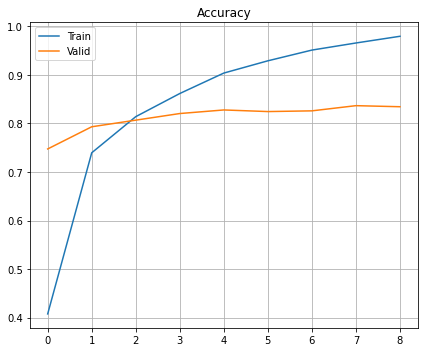

In [ ]:
plt.figure(figsize=(6,5))

plt.plot(train_acces)
plt.plot(valid_acces)
plt.title('Accuracy')
plt.legend(['Train','Valid'])
plt.grid(True)

plt.tight_layout()
plt.show()

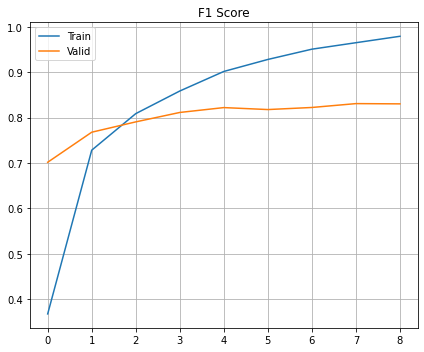

In [ ]:
plt.figure(figsize=(6,5))

plt.plot(train_f1s)
plt.plot(valid_f1s)
plt.title('F1 Score')
plt.legend(['Train','Valid'])
plt.grid(True)

plt.tight_layout()
plt.show()

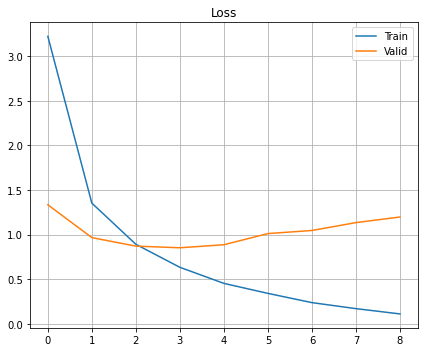

In [ ]:
plt.figure(figsize=(6,5))

plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('Loss')
plt.legend(['Train','Valid'])
plt.grid(True)

plt.tight_layout()
plt.show()

### Inference

In [ ]:
class CategoryDataset(Dataset):
  def __init__(self, text, image_path, tokenizer, feature_extractor, max_len):
    self.text = text
    self.image_path = image_path
    self.tokenizer = tokenizer
    self.feature_extractor = feature_extractor
    self.max_len = max_len
  def __len__(self):
    return len(self.text)
  def __getitem__(self, item):
    text = str(self.text[item])
    image_path = str(self.image_path[item])[2:]
    image = cv2.imread(image_path)
    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding = 'max_length',
      truncation = True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    image_feature = self.feature_extractor(images=image, return_tensors="pt")
    return {
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'pixel_values': image_feature['pixel_values'][0],
    }

def create_data_loader(df, tokenizer, feature_extractor, max_len, batch_size, shuffle_=False):
    ds = CategoryDataset(
        text=df.overview.to_numpy(),
        image_path = df.img_path.to_numpy(),
        tokenizer=tokenizer,
        feature_extractor = feature_extractor,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4,
        shuffle = shuffle_
    )

In [ ]:
def inference(model,data_loader,device,n_examples):
  model = model.eval()
  preds_arr3 = []
  for d in tqdm(data_loader):
    with torch.no_grad():
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      pixel_values = d['pixel_values'].to(device)

      outputs3 = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        pixel_values=pixel_values
      )

      _, preds3 = torch.max(outputs3, dim=1)

      preds_arr3.append(preds3.cpu().numpy())

      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

  return preds_arr3


In [ ]:
test = pd.read_csv('./test.csv')

In [ ]:
eval_data_loader = create_data_loader(test, tokenizer, feature_extractor, 256, 1)

preds_arr3 = inference(
        model,
        eval_data_loader,
        device,
        len(test)
        )

100%|██████████| 7280/7280 [19:41<00:00,  6.16it/s]


In [ ]:
sample_submission = pd.read_csv('./sample_submission.csv')
sample_submission['cat3'] = le.inverse_transform(preds_arr3)

In [ ]:
sample_submission

,id,cat3
0,TEST_00000,한식
1,TEST_00001,한식
2,TEST_00002,한식
3,TEST_00003,수련시설
4,TEST_00004,산
...,...,...
7275,TEST_07275,한식
7276,TEST_07276,공연장
7277,TEST_07277,"야영장,오토캠핑장"
7278,TEST_07278,모텔


In [ ]:
test['pred'] = sample_submission['cat3']

In [ ]:
sample_submission.to_csv('roberta_vit_final.csv',index=False)

In [ ]:
answer = pd.read_csv('final_pred.csv')
answer

,id,img_path,overview,cat3
0,TEST_00000,./image/test/TEST_00000.jpg,신선한 재료로 정성을 다해 만들었다. 늘 변함없는 맛과 서비스로 모실것을 약속한다.,한식
1,TEST_00001,./image/test/TEST_00001.jpg,"청청한 해역 등량만과 율포해수욕장이 한눈에 내려다 보이는 위치에 있으며, 막 잡은 ...",한식
2,TEST_00002,./image/test/TEST_00002.jpg,장터설렁탕은 남녀노소 누구나 즐길 수 있는 전통 건강식으로 좋은 재료와 전통 조리방...,한식
3,TEST_00003,./image/test/TEST_00003.jpg,다양한 형태의 청소년수련활동을 제공함으로써 청소년들이 민주사회의 주역이 될 수 있도...,수련시설
4,TEST_00004,./image/test/TEST_00004.jpg,팔공산은 경산시의 북쪽에 위치한 해발 1192.3 m의 높은 산으로 신라시대에는 중...,산
...,...,...,...,...
7275,TEST_07275,./image/test/TEST_07275.jpg,"막국수와 수육을 주메뉴로 하며, 넓은 주차장이 마련되어 있어 주차하기 편리하다.<br>",한식
7276,TEST_07276,./image/test/TEST_07276.jpg,"통진두레문화센터는 우리고유의 전통무형문화와 민속예술을 계승/발전 시키고, 다양한 문...",공연장
7277,TEST_07277,./image/test/TEST_07277.jpg,"수도권에서 가까운 위치, 문산천을 따라 걷는 산책코스, 한여름 더위를 날려버릴 시원...","야영장,오토캠핑장"
7278,TEST_07278,./image/test/TEST_07278.jpg,\n전남 구례군 관산리에 위치한 노고단 게스트하우스&호텔은 지리산을 파노라마로 관망...,게스트하우스


In [ ]:
f1_score(answer.cat3, sample_submission.cat3, average='weighted')

0.8728004138567742

In [ ]:
accuracy_score(answer.cat3, sample_submission.cat3)

0.8744505494505495

In [ ]:
for i in tqdm(range(test.shape[0])):
    text = test.iloc[i, 2]
    text = text.replace('<br>',' ').replace('<br/>',' ').replace('*',' ').replace('<br /',' ').replace('&nbsp;',' ').replace('<a/>',' ').replace('<a />',' ').replace('\n',' ').replace('\t',' ')
    test.iloc[i, 2] = text

100%|██████████| 7280/7280 [00:00<00:00, 8552.32it/s]


In [ ]:
cnt_df = pd.read_csv('cnt_final.csv')
cnt_df

,cat1,cat2,cat3,count
0,음식,음식점,한식,3432
1,레포츠,육상 레포츠,"야영장,오토캠핑장",1634
2,음식,음식점,바/까페,865
3,인문(문화/예술/역사),역사관광지,유적지/사적지,696
4,인문(문화/예술/역사),축제,일반축제,611
...,...,...,...,...
122,인문(문화/예술/역사),공연/행사,뮤지컬,4
123,인문(문화/예술/역사),공연/행사,대중콘서트,4
124,레포츠,육상 레포츠,ATV,3
125,레포츠,육상 레포츠,인라인(실내 인라인 포함),2


In [ ]:
cnt_df.drop('count', axis=1, inplace=True)
cnt_df

,cat1,cat2,cat3
0,음식,음식점,한식
1,레포츠,육상 레포츠,"야영장,오토캠핑장"
2,음식,음식점,바/까페
3,인문(문화/예술/역사),역사관광지,유적지/사적지
4,인문(문화/예술/역사),축제,일반축제
...,...,...,...
122,인문(문화/예술/역사),공연/행사,뮤지컬
123,인문(문화/예술/역사),공연/행사,대중콘서트
124,레포츠,육상 레포츠,ATV
125,레포츠,육상 레포츠,인라인(실내 인라인 포함)


In [ ]:
cat_dic = {}
for i in range(cnt_df.shape[0]):
    cat_dic[cnt_df.iloc[i,2]] = [cnt_df.iloc[i,0], cnt_df.iloc[i,1]]

In [ ]:
test['cat1'] = np.nan
test['cat2'] = np.nan
test

for i in range(test.shape[0]):
    for j in cat_dic.keys():
        if test.pred[i] == j:
            test.cat1[i] = cat_dic[j][0]
            test.cat2[i] = cat_dic[j][1]

In [ ]:
test

,id,img_path,overview,cat1,cat2,pred
0,TEST_00000,./image/test/TEST_00000.jpg,신선한 재료로 정성을 다해 만들었다. 늘 변함없는 맛과 서비스로 모실것을 약속한다.,음식,음식점,한식
1,TEST_00001,./image/test/TEST_00001.jpg,"청청한 해역 등량만과 율포해수욕장이 한눈에 내려다 보이는 위치에 있으며, 막 잡은 ...",음식,음식점,한식
2,TEST_00002,./image/test/TEST_00002.jpg,장터설렁탕은 남녀노소 누구나 즐길 수 있는 전통 건강식으로 좋은 재료와 전통 조리방...,음식,음식점,한식
3,TEST_00003,./image/test/TEST_00003.jpg,다양한 형태의 청소년수련활동을 제공함으로써 청소년들이 민주사회의 주역이 될 수 있도...,인문(문화/예술/역사),문화시설,수련시설
4,TEST_00004,./image/test/TEST_00004.jpg,팔공산은 경산시의 북쪽에 위치한 해발 1192.3 m의 높은 산으로 신라시대에는 중...,자연,자연관광지,산
...,...,...,...,...,...,...
7275,TEST_07275,./image/test/TEST_07275.jpg,"막국수와 수육을 주메뉴로 하며, 넓은 주차장이 마련되어 있어 주차하기 편리하다.",음식,음식점,한식
7276,TEST_07276,./image/test/TEST_07276.jpg,"통진두레문화센터는 우리고유의 전통무형문화와 민속예술을 계승/발전 시키고, 다양한 문...",인문(문화/예술/역사),문화시설,공연장
7277,TEST_07277,./image/test/TEST_07277.jpg,"수도권에서 가까운 위치, 문산천을 따라 걷는 산책코스, 한여름 더위를 날려버릴 시원...",레포츠,육상 레포츠,"야영장,오토캠핑장"
7278,TEST_07278,./image/test/TEST_07278.jpg,전남 구례군 관산리에 위치한 노고단 게스트하우스&호텔은 지리산을 파노라마로 관망할...,숙박,숙박시설,모텔


In [ ]:
test.to_csv('fffinal_test_roberta_vit.csv', index=False)